# Classification
## 1. MINIST
MINIST dataset (Modified National Institute of Standards and Technology database) is a set of 70,000 images of handwritten digits, each of which is labeled with represented digit.

In [1]:
'''from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist'''

from scipy.io import loadmat

mnist = loadmat('mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [2]:
X,y = mnist['data'].T, mnist['label'].flatten()
X.shape, y.shape

((70000, 784), (70000,))

There are 784 features because there are $28\times28$ features for each image, from 0 (white) to 256 (black).

In [3]:
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape((28,28))
fig,ax = plt.subplots()
ax.imshow(some_digit_image, cmap=plt.cm.binary, interpolation='nearest')
plt.show()
print('Label: ',int(y[36000]))

<Figure size 640x480 with 1 Axes>

Label:  5


The MNIST dataset has already been split into training and test sets, but we still need to shuffle the training set.

In [4]:
import numpy as np

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X[shuffle_index],y[shuffle_index]

## 2. Training a Binary Classifier
First develope a binary classfier to tell if a digit is 5 or not.

In [5]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

Start with a SGD classifier, which is good at handling big datasets. The SGD algorithm relies on randomness during training, so that the *random_state* should be clarified if results need reproducing

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
sgd_clf.predict([some_digit]) #should be true

array([ True])

## 3. Performance Measure
### 3.1 Measuring Accuracy Using Cross-Validation

In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95375, 0.96375, 0.95805])

Although this classifier looks like performing well (accuracy above 95%), we should wait and see the performace of a classifier that never predicts 5.

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9062 , 0.90925, 0.9135 ])

While this classifier makes no sense, it still has an accuracy of over 90%, and this is because only about 10% of all images represents 5.  

This demonstates why accuracy is not preferred for classifiers, especially when you are dealing with skewed datasets when some classes overwhelms some others (non-5 and 5).
### 3.2 Confusion Matrix
The general idea of Confusion Matrix is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53036,  1543],
       [  946,  4475]], dtype=int64)

Schema of confusion matrix:
![confusion_matrix](confusion.png)
Some equations may also help to better understand confusion matrix:
$$precision = \frac{TP}{TP+FP}$$
$$recall = \frac{TP}{TP+FN}$$

### 3.3 Precision and Recall

In [10]:
from sklearn.metrics import precision_score, recall_score

print('Precision: ', precision_score(y_train_5, y_train_pred))
print('Recall: ', recall_score(y_train_5, y_train_pred))

Precision:  0.7436025257560651
Recall:  0.825493451392732


Now the classifier does not seem so good, because only 76.5% of claimed 5s are correct, and  76.0% of 5s are detected.
F1 score, which combines both precision and recall score could be quite useful when comparing two classfiers. Mathematically, it is the harmoic mean of precision and recall score.
$$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2\times \frac{precision\times recall}{precision+recall}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

In [11]:
from sklearn.metrics import f1_score

print('F1: ', f1_score(y_train_5, y_train_pred))

F1:  0.7824110499169508


The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection).  

On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).  

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall tradeoff*.

### 3.4 Precision/Recall Tradeoff
The tradeoff could be shown as below:
![tradeoff](tradeoff.png)
For each instance, a score is computed by a decision fuction. If the score is greater than a threshold, then the instance will be labeled as positive, *vice versa*.  

Sklearn provides access to the decision scores used to make predictions, and then you can reset a prefered threshold.

In [12]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[3600.69412669]
[ True]


In [13]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Rasing threshold would decrease the recall score.

How to decide the threshold? It is better to start with computing scores of all instances.

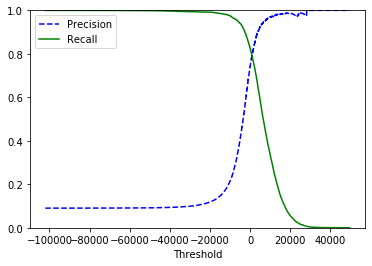

In [14]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,\
                            method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

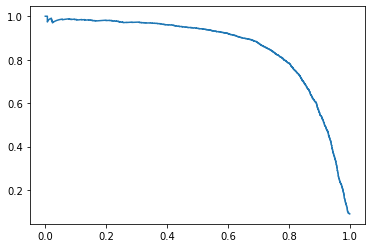

In [15]:
plt.plot(recalls, precisions)

If reset threshold to 10000:

In [16]:
y_train_pred_95 = (y_scores>10000)
print('Precision: ',precision_score(y_train_5,y_train_pred_95))
print('Recall: ',recall_score(y_train_5,y_train_pred_95))

Precision:  0.9691325172964342
Recall:  0.3359158826784726


### 3.5 The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity. 

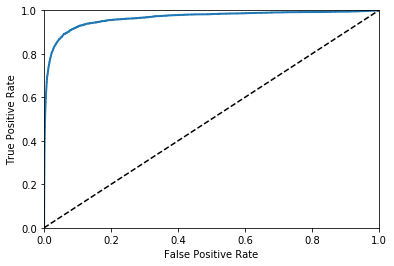

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) 

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [18]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9648101973456772

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works, the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class.

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score.

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will ra

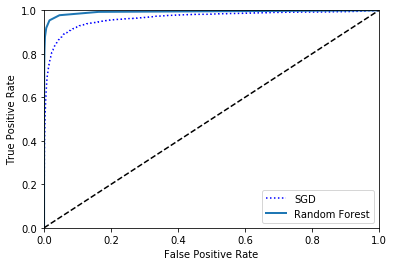

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method='predict_proba')
y_scores_forest = y_proba_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='bottom right')
plt.show()

The RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the topleft corner. As a result, its ROC AUC score is also significantly better.

In [20]:
roc_auc_score(y_train_5,y_scores_forest)

0.992769006490388

In [21]:
y_train_forest_pred = cross_val_predict(forest_clf, X_train,y_train_5,cv=3)
print('Precision: ',precision_score(y_train_5,y_train_forest_pred))
print('Recall: ',recall_score(y_train_5,y_train_forest_pred))

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:  0.9859469105509703
Recall:  0.815347721822542


# 4. Multiclass Classification
One way to build a multiclass classifier is to combine binary classfiers. When you want to predict the label of one instance, compute scores of all binary classfiers and use the highest one as the label. This method is called the one-versus-all (OvA) stategy, or the one-versus-the-rest.

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [22]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

Instead of returning just one score per instance, it now returns 10 scores, one per class.

In [23]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(sgd_clf.classes_)
print(sgd_clf.classes_[np.argmax(some_digit_scores)])

[[ -9787.91952499 -20715.23607202 -13103.13796885  -1599.05614498
  -14024.66096659   2591.7340861  -33526.37966934 -14017.60853342
   -8706.57246068 -16982.26088419]]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
5.0


If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor. 

In [24]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5.]
45


In [25]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.85012997, 0.86389319, 0.88318248])

It gets over 87% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score. However, it could still be improved by scaling.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
#cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

## 5. Error Analysis

In [27]:
#y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
#conf_mx = confusion_matrix(y_train,y_train_pred)
#conf_mx

In [28]:
conf_mx_not = np.array([[5725,3,24,9,10,49,50,10,39,4],[2,6493,43,25,7,40,5,10,109,8],[51,41,5321,104,89,26,87,60,166,13],[47,46,141,5342,1,231,40,50,141,92],[19,29,41,10,5366,9,56,37,86,189],[73,45,36,193,64,4582,111,30,193,94],[29,34,44,2,42,85,5627,10,45,0],[25,24,74,32,54,12,6,5787,15,236],[52,161,73,156,10,163,61,25,5027,123],[43,35,26,92,178,28,2,223,82,5240]]) 

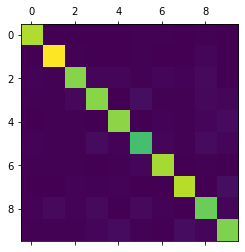

In [29]:
fig1, ax1 = plt.subplots()
ax1.matshow(conf_mx_not)

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case. 

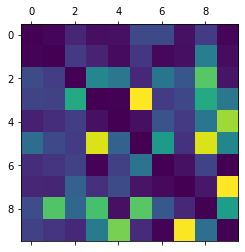

In [30]:
row_sums = conf_mx_not.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx_not/row_sums #error rate
np.fill_diagonal(norm_conf_mx, 0) #keep only the errors
fig2, ax2 = plt.subplots()
ax2.matshow(norm_conf_mx)

Remember that rows are actual classes, and columns represent predicted classes. The columns for classes 8 and 9 are quite bright, which tells you that many images get misclassified as 8s or 9s. Similarly, the rows for classes 8 and 9 are also quite bright, telling you that 8s and 9s are often confused with other digits.

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on improving classification of 8s and 9s, as well as fixing the specific 3/5 confusion. For example, you could try to gather more training data for these digits. Or you could engineer new features that would help the classifier — for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops. 

## 5. Multilabel Classification
Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

y_multilabel

array([[False, False],
       [False, False],
       [False,  True],
       ...,
       [False, False],
       [ True,  True],
       [False, False]])

In [32]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)
knn_clf.predict([some_digit]) #should be [False, True]

array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. For example, one approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels.

This assumes that all labels are equally important, which may not be the case. Simply set *average='weighted'* could weight each labels for scoring.

In [33]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
#f1_score(y_train, y_train_knn_pred, average='macro')

## 6. Multioutput Classification
Multioutput Classification, or Multioutput-Multiclass Classification. It is simply a generalization of multilabel classification where each label can be multiclass (*i.e.* it can have more than two possible values). 

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities.

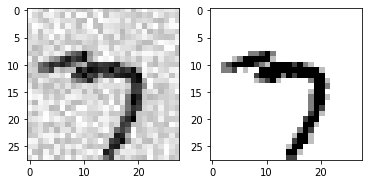

In [34]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
y_train_mod = X_train

fig3,ax3 = plt.subplots(1,2)
ax3[0].imshow(X_train_mod[36000].reshape((28,28)), cmap=plt.cm.binary, interpolation='nearest')
ax3[1].imshow(y_train_mod[36000].reshape((28,28)), cmap=plt.cm.binary, interpolation='nearest')
plt.show()

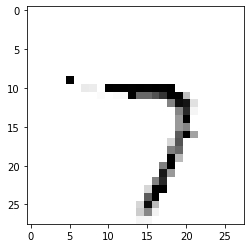

In [35]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[36000]])
fig4,ax4 = plt.subplots()
ax4.imshow(clean_digit.reshape((28,28)), cmap=plt.cm.binary, interpolation='nearest')
plt.show()